In [1]:
# PennyLane imports
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer

from scipy.optimize import differential_evolution, minimize

# General imports
import os
import json
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from qiskit.quantum_info import SparsePauliOp

# custom module
from susy_qm import calculate_Hamiltonian, create_plots

In [2]:
potential = 'QHO'
#potential = 'AHO'
#potential = 'DW'
cut_off = 2

In [3]:
#calculate Hamiltonian and expected eigenvalues
H = calculate_Hamiltonian(cut_off, potential)
eigenvalues = np.sort(np.linalg.eig(H)[0])
min_eigenvalue = min(eigenvalues.real)

#create qiskit Hamiltonian Pauli string
hamiltonian = SparsePauliOp.from_operator(H)
num_qubits = hamiltonian.num_qubits

In [4]:
num_qubits

2

In [5]:
#Initial params shape
num_layers = 1
params_shape = qml.StronglyEntanglingLayers.shape(n_layers=num_layers, n_wires=num_qubits)

In [6]:
def ansatz(params, wires):
    params = pnp.tensor(params.reshape(params_shape), requires_grad=True)
    qml.StronglyEntanglingLayers(weights=params, wires=wires, imprimitive=qml.CZ)

In [12]:
# Device
shots = None
dev = qml.device('lightning.qubit', wires=2*num_qubits+1, shots=shots)

@qml.qnode(dev)
def swap_test(params1, params2):

    params1 = pnp.tensor(params1.reshape(params_shape), requires_grad=True)
    params2 = pnp.tensor(params2.reshape(params_shape), requires_grad=True)

    ancilla = 2*num_qubits
    qml.Hadamard(wires=ancilla)

    ansatz(params1, wires=range(num_qubits))
    ansatz(params2, wires=range(num_qubits, 2*num_qubits))

    qml.Barrier()  # added to better visualise the circuit
    for i in range(num_qubits):
        qml.CSWAP(wires=[ancilla, i, num_qubits + i])

    qml.Hadamard(wires=ancilla)

    return qml.probs(wires=ancilla)

In [13]:
# Example parameters for testing the swap test
params1 = np.random.uniform(0, 2 * np.pi, size=qml.StronglyEntanglingLayers.shape(1, num_qubits))
params2 = np.random.uniform(0, 2 * np.pi, size=qml.StronglyEntanglingLayers.shape(1, num_qubits))

# Run the swap test to get the probability of the ancilla being |0>
result = swap_test(params1, params2)

# The overlap is given by 2 * P(ancilla=0) - 1
#overlap = 2 * result[0] - 1

print(qml.draw(swap_test)(params1,params2))
print(f"\nOverlap between the ground state and the ansatz: {result}")

0: ──Rot(3.23,5.43,5.56)─╭●─╭Z──||─╭SWAP──────────┤       
1: ──Rot(5.12,2.70,2.49)─╰Z─╰●──||─│─────╭SWAP────┤       
2: ──Rot(2.61,3.44,3.48)─╭●─╭Z──||─├SWAP─│────────┤       
3: ──Rot(6.02,6.25,0.11)─╰Z─╰●──||─│─────├SWAP────┤       
4: ──H──────────────────────────||─╰●────╰●─────H─┤  Probs

Overlap between the ground state and the ansatz: [0.50338967 0.49661033]


In [68]:
# Device
shots = None
dev2 = qml.device('lightning.qubit', wires=num_qubits, shots=shots)

@qml.qnode(dev2)
def expected_value(params):
    wires = range(num_qubits)
    ansatz(params, wires)
    return qml.expval(qml.Hermitian(H, wires=range(num_qubits)))


def loss_f(params):
    global prev_param_list, beta
    energy = expected_value(params)

    penalty = 0

    if len(prev_param_list) != 0:
        for prev_param in prev_param_list:
            overlap =  swap_test(prev_param, params)[0] - 0.5
            penalty += overlap

    return energy + (penalty)

In [88]:
def callback(xk, convergence=None):
    global iteration_counter, counts, values, steps

    iteration_counter += 1

    current_value = loss_f(xk)

    counts.append(iteration_counter)
    values.append(current_value)           
    steps.append(xk.copy())                

In [70]:
#Optimizer
stepsize = 0.05
optimizer = AdamOptimizer(stepsize=stepsize)

In [92]:
vqd_start = datetime.now()

#variables
num_vqd_runs = 4
max_iterations = 5000
beta = 300.0
tolerance = 1e-6
moving_avg_length = 5

#data arrays
energies = []
prev_param_list = []

all_counts = []
all_values = []
all_steps = []

all_overlaps = []

for i in range(num_vqd_runs):

    run_start = datetime.now()
    converged = False
    prev_energy = None

    moving_average_check = False
    gradient_norm_check = False

    iteration_counter = 0
    counts = []
    values = []
    steps = []

    #Initial params
    scale = 0.25
    params_shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=num_qubits)
    params = scale*np.pi * pnp.random.random(size=params_shape)

    if i % 1 == 0:
        print(f"Run: {i}")

    iter_energies = []

    for _ in range(max_iterations):

        params, energy = optimizer.step_and_cost(loss_f, params)
        iter_energies.append(energy)

        counts.append(_+1)
        values.append(energy)  

        # Moving average convergence check
        if len(iter_energies) > moving_avg_length:
            energy_moving_avg = np.mean(np.abs(np.diff(iter_energies[-moving_avg_length:])))
            if energy_moving_avg < tolerance:
                moving_average_check = True
                converged = True
                break
    
    all_counts.append(counts)
    all_values.append(values)
    all_steps.append(steps)            

    print(converged)
    energies.append(energy)
    prev_param_list.append(params) 
    print(energies)

    

    # Calculate overlap with all previous states
    overlaps = []
    if i > 0:
        for j in range(i):
            overlap = swap_test(prev_param_list[j], params)[0]
            overlaps.append(overlap)
        all_overlaps.append(overlaps)
        print(f"Overlaps with all previous states for run {i}: {overlaps}")


Run: 0
True
[2.1048782340158137e-08]
Run: 1
True
[2.1048782340158137e-08, 1.6257640724043934e-05]
Overlaps with all previous states for run 1: [0.5000092015227796]
Run: 2
True
[2.1048782340158137e-08, 1.6257640724043934e-05, 0.49787963526582873]
Overlaps with all previous states for run 2: [0.7869860200509589, 0.7108925766147145]
Run: 3
True
[2.1048782340158137e-08, 1.6257640724043934e-05, 0.49787963526582873, 0.502121344583155]
Overlaps with all previous states for run 3: [0.7124668797734862, 0.7896412300316156, 0.5000007761688332]


In [77]:
energies

[3.523069670949762e-11, 1.6404396713831206e-05, 0.4999612235918407]

In [90]:
all_values

[[0.9558097799278561,
  0.9509245845638863,
  0.9417345993882684,
  0.9282155413648061,
  0.9101508067695008,
  0.8873253170863583,
  0.8596228784440648,
  0.827069234486999,
  0.7898430125434355,
  0.7482693413553856,
  0.7028055212499053,
  0.6540236697257616,
  0.60259225166041,
  0.5492568293586233,
  0.4948197935840073,
  0.4401187955747136,
  0.38600378047806844,
  0.33331276737394444,
  0.28284676926928265,
  0.23534448326563145,
  0.19145760676699342,
  0.15172784891549632,
  0.1165668957741618,
  0.08624072584189338,
  0.06085971468607673,
  0.04037585583072073,
  0.024588100850578904,
  0.013156248372622152,
  0.00562300443498793,
  0.0014428865807521855,
  1.5720938820661625e-05,
  0.0007218000446880255,
  0.0029555211013528727,
  0.0061546021504805875,
  0.009822723876764595,
  0.013544481325376754,
  0.016992602421107256,
  0.019928273995193282,
  0.022195978131298925,
  0.023714459718486968,
  0.024465383567900536,
  0.024481000241368685,
  0.023831826733893217,
  0.02261

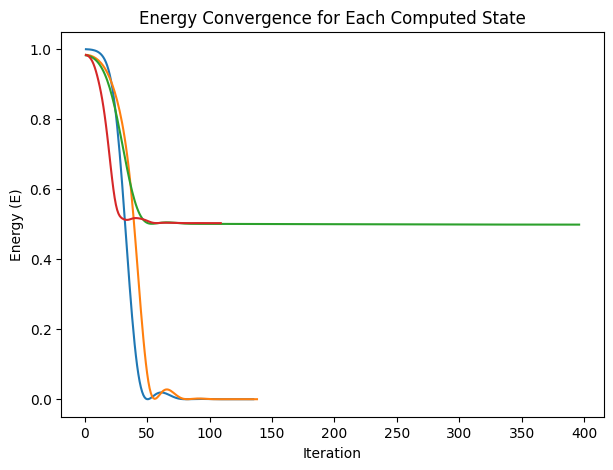

In [93]:
# Plotting each line for different states
plt.figure(figsize=(7, 5))  # Set figure size similar to the uploaded image

for i in range(num_vqd_runs):
    plt.plot(all_counts[i], all_values[i])# label=f"State {i}")

# Set axis labels and title
plt.xlabel("Iteration")
plt.ylabel("Energy (E)")
plt.title("Energy Convergence for Each Computed State")

# Set y-axis to logarithmic scale
#plt.yscale("log")
#plt.ylim(-1.0, 10)

# Display legend
#plt.legend(loc="upper right")

# Show plot
plt.show()
